<a href="https://colab.research.google.com/github/stswee/ECE219/blob/main/ECE219_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [27]:
# Import libraries
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD, NMF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Part 1 - Clustering on Text Data

## Clustering with Sparse Text Representations

### Question 1

In [28]:
# Preprocessing functions
def clean(text) -> str:
  """
  Processes the text based on rules.

  Parameters
  ----------
  text : str
    The string to process.

  Returns
  -------
  str
    The processed string.
  """
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

def remove_numbers(text = str) -> str:
  """
  Removes numbers from the text.

  Parameters
  ----------
  text : str
    The string to remove numbers from.

  Returns
  -------
  str
    The string with numbers removed.
  """

  # Remove numbers
  return re.sub(r'\b\d+\b', '', text)

def remove_punctuation(text = str) -> str:
  """
  Removes punctuation from the text.

  Parameters
  ----------
  text : str
    The string to remove punctuation from.

  Returns
  -------
  str
    The string with punctuation removed.
  """

  # Remove punctuation
  return re.sub(r'[^\w\s]', '', text)

def preprocessing(df = pd.DataFrame, preprocessing_functions = list) -> pd.DataFrame:
  """
  Preprocesses the text in the dataframe.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to preprocess.
  preprocessing_functions : list
    The list of preprocessing functions to apply.

  Returns
  -------
  pd.DataFrame
    The preprocessed dataframe.
  """

  # Initialize dataframe
  df_copy = df.copy()

  # Apply preprocessing functions
  for preprocessing_function in preprocessing_functions:
    df_copy.map(preprocessing_function)

  return df_copy

In [ ]:
# Select categories
cats = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
        'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

# Load in data (takes about 20 seconds)
newsgroups = fetch_20newsgroups(subset='all', categories = cats)
# newsgroups_train = fetch_20newsgroups(subset='train', categories = cats)
# newsgroups_test = fetch_20newsgroups(subset='test', categories = cats)

# Convert to pandas dataframe
newsgroups_df = pd.DataFrame(newsgroups.data, columns=['text'])
newsgroups_labels = newsgroups.target
# newsgroups_train_df = pd.DataFrame(newsgroups_train.data, columns = ['text'])
# newsgroups_train_df['target'] = newsgroups_train.target
# newsgroups_test_df = pd.DataFrame(newsgroups_test.data, columns = ['text'])
# newsgroups_test_df['target'] = newsgroups_test.target

# Preprocess labels (0 - 3 -> 0, 4 - 7 -> 1; let computers be the 0 label and rec be the 1 label)
newsgroups_labels = np.where(newsgroups_labels < 4, 0, 1)

# Perform preprocessing
preprocessing_functions = [clean, remove_numbers, remove_punctuation]
newsgroups_df = preprocessing(newsgroups_df, preprocessing_functions)
# newsgroups_train_df = preprocessing(newsgroups_train_df, preprocessing_functions)
# newsgroups_test_df = preprocessing(newsgroups_test_df, preprocessing_functions)

# Initialize CountVectorizer and TfidfTransformer
count_vect = CountVectorizer(stop_words = 'english', min_df = 3)
tfidf_transformer = TfidfTransformer()

# Remove stopwords and convert to TF-IDF matrix
X_counts = count_vect.fit_transform(newsgroups_df['text'])
X_tfidf = tfidf_transformer.fit_transform(X_counts)
# X_train_counts = count_vect.fit_transform(newsgroups_train_df['text'])
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_test_counts = count_vect.transform(newsgroups_test_df['text'])
# X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Report shape of TF-IDF matrices
print("Shape of X_tfidf:", X_tfidf.shape)
# print("Shape of X_train_tfidf:", X_train_tfidf.shape)
# print("Shape of X_test_tfidf:", X_test_tfidf.shape)

# TODO: Check if headers/footers removed and whether to use entire newsgroup dataset

Shape of X_tfidf: (7882, 27768)


### Question 2

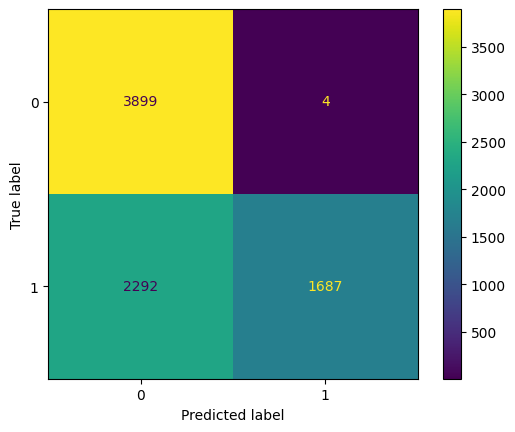

In [29]:
# Apply K-means clustering
# Create model (takes about 10 seconds to fit with these configurations)
kmeans = KMeans(n_clusters = 2, random_state = 0, max_iter = 10000, n_init = 50)

# Fit model to data
kmeans.fit(X_tfidf)

# Get labels for each data point
labels = kmeans.labels_

# Create confusion matrix (0 = computers, 1 = rec)
cm = confusion_matrix(newsgroups_labels, labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = set(kmeans.labels_))
disp.plot()
plt.show()

### Question 3

In [30]:
# Calculate homogeneity
homogeneity = metrics.homogeneity_score(newsgroups_labels, labels)
print("Homogeneity:", homogeneity)

# Calculate completeness
completeness = metrics.completeness_score(newsgroups_labels, labels)
print("Completeness:", completeness)

# Calculate V-measure
v_measure = metrics.v_measure_score(newsgroups_labels, labels)
print("V-measure:", v_measure)

# Calculate Adjusted Rand Index
ari = metrics.adjusted_rand_score(newsgroups_labels, labels)
print("Adjusted Rand Index:", ari)

# Calculate Adjusted Mutual Information
ami = metrics.adjusted_mutual_info_score(newsgroups_labels, labels)
print("Adjusted Mutual Information:", ami)

Homogeneity: 0.24794628349395062
Completeness: 0.33054175148611625
V-measure: 0.28334760224863614
Adjusted Rand Index: 0.1741327386002284
Adjusted Mutual Information: 0.28327261469368775


## Clustering with Dense Text Representations

### Question 4

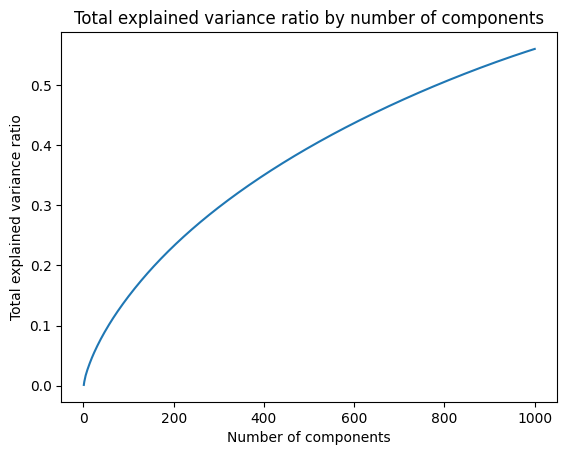

In [ ]:
# Experiment with different explained variance ratios
# Calculate r = 1000 components first, then subtract 1 for r = 999, 998, ..., 1
# Takes about a minute to run
r = 1000
svd = TruncatedSVD(n_components = r)
lsa_matrix = svd.fit_transform(X_tfidf)
explained_variance_ratio = svd.explained_variance_ratio_
total_explained_variance = []
for i in range(1000):
  total_explained_variance.append(sum(explained_variance_ratio[:i+1]))

# Plot
plt.plot(range(1, 1001), total_explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance ratio')
plt.title('Total explained variance ratio by number of components')
plt.show()

### Question 5

In [36]:
# Number of components
comps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# SVD/NMF
model = ['svd', 'nmf']

# Create tuples for SVD/NMF and number of components to be used as keys
parameters = [(model, r) for model in model for r in comps]

# Initialize list to store metrics
homogeneity_metrics = []
completeness_metrics = []
v_measure_metrics = []
ari_metrics = []
ami_metrics = []

# Create model
# Can modify configurations as needed; max_iter and n_init minimized for speed
kmeans = KMeans(n_clusters = 2, random_state = 0, max_iter = 1000, n_init = 30)

# Perform dimensionality reduction and clustering, then retrieve metrics
# About 6 minutes to run
for parameter in parameters:

  # Get model and number of components
  model, r = parameter

  # SVD
  if model == 'svd':
    svd = TruncatedSVD(n_components = r)
    lsa_matrix = svd.fit_transform(X_tfidf)

    # Fit
    kmeans.fit(lsa_matrix)

    # Get labels for each data point
    labels = kmeans.labels_

    # Calculate metrics
    homogeneity_metrics.append(metrics.homogeneity_score(newsgroups_labels, labels))
    completeness_metrics.append(metrics.completeness_score(newsgroups_labels, labels))
    v_measure_metrics.append(metrics.v_measure_score(newsgroups_labels, labels))
    ari_metrics.append(metrics.adjusted_rand_score(newsgroups_labels, labels))
    ami_metrics.append(metrics.adjusted_mutual_info_score(newsgroups_labels, labels))

  # NMF
  # Question to ask TA: If NMR for r = 300 takes too long to converge, can we ignore?
  # r = 300 takes a long time to converge, so ignore
  elif model == 'nmf' and r == 300:
    # Assign metrics to zero
    homogeneity_metrics.append(0)
    completeness_metrics.append(0)
    v_measure_metrics.append(0)
    ari_metrics.append(0)
    ami_metrics.append(0)

  elif model == 'nmf':
    nmf = NMF(n_components = r, init = 'random', random_state = 0)
    nmf_matrix = nmf.fit_transform(X_tfidf)

    # fit
    kmeans.fit(nmf_matrix)

    # Get labels for each data point
    labels = kmeans.labels_

    # Calculate metrics
    homogeneity_metrics.append(metrics.homogeneity_score(newsgroups_labels, labels))
    completeness_metrics.append(metrics.completeness_score(newsgroups_labels, labels))
    v_measure_metrics.append(metrics.v_measure_score(newsgroups_labels, labels))
    ari_metrics.append(metrics.adjusted_rand_score(newsgroups_labels, labels))
    ami_metrics.append(metrics.adjusted_mutual_info_score(newsgroups_labels, labels))

# Put data into pandas dataframe
metrics_df = pd.DataFrame({'Model': [parameter[0] for parameter in parameters],
                           'Number of components': [parameter[1] for parameter in parameters],
                           'Homogeneity': homogeneity_metrics,
                           'Completeness': completeness_metrics,
                           'V-measure': v_measure_metrics,
                           'Adjusted Rand Index': ari_metrics,
                           'Adjusted Mutual Information': ami_metrics})

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [45]:
metrics_df

,Model,Number of components,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information
0,svd,1,0.000284,0.000289,0.000286,0.000317,0.000194
1,svd,2,0.590032,0.591670,0.590849,0.689269,0.590812
2,svd,3,0.387488,0.428837,0.407116,0.375122,0.407059
3,svd,4,0.233088,0.313639,0.267430,0.164318,0.267353
4,svd,5,0.221520,0.309832,0.258337,0.144962,0.258258
5,svd,6,0.220301,0.308907,0.257186,0.143613,0.257107
6,svd,7,0.222393,0.310493,0.259160,0.145931,0.259081
7,svd,8,0.230552,0.318152,0.267359,0.153195,0.267282
8,svd,9,0.236939,0.322961,0.273341,0.160432,0.273265
9,svd,10,0.232143,0.319350,0.268851,0.154988,0.268774


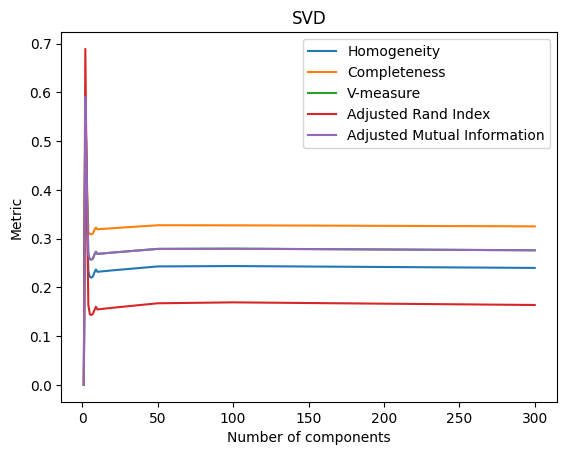

In [42]:
# Get SVD rows and plot number of components vs. each metric
svd_df = metrics_df[metrics_df['Model'] == 'svd']

# Plot number of components vs metric
plt.plot(svd_df['Number of components'], svd_df['Homogeneity'], label = 'Homogeneity')
plt.plot(svd_df['Number of components'], svd_df['Completeness'], label = 'Completeness')
plt.plot(svd_df['Number of components'], svd_df['V-measure'], label = 'V-measure')
plt.plot(svd_df['Number of components'], svd_df['Adjusted Rand Index'], label = 'Adjusted Rand Index')
plt.plot(svd_df['Number of components'], svd_df['Adjusted Mutual Information'], label = 'Adjusted Mutual Information')
plt.xlabel('Number of components')
plt.ylabel('Metric')
plt.title('SVD')
plt.legend()
plt.show()

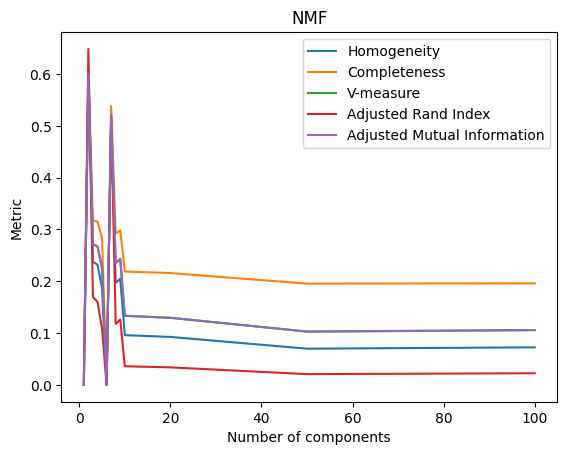

In [44]:
# Get NMF rows and plot number of components vs. each metric
nmf_df = metrics_df[metrics_df['Model'] == 'nmf']

# Exclude 300 components
nmf_df = nmf_df[nmf_df['Number of components'] != 300]

# Plot number of components vs metric
plt.plot(nmf_df['Number of components'], nmf_df['Homogeneity'], label = 'Homogeneity')
plt.plot(nmf_df['Number of components'], nmf_df['Completeness'], label = 'Completeness')
plt.plot(nmf_df['Number of components'], nmf_df['V-measure'], label = 'V-measure')
plt.plot(nmf_df['Number of components'], nmf_df['Adjusted Rand Index'], label = 'Adjusted Rand Index')
plt.plot(nmf_df['Number of components'], nmf_df['Adjusted Mutual Information'], label = 'Adjusted Mutual Information')
plt.xlabel('Number of components')
plt.ylabel('Metric')
plt.title('NMF')
plt.legend()

Visually, the optimal model has r = 2 for both SVD and NMR. The metrics dataframe also supports this.

### Question 6

TODO

### Question 7

Using SVD, using 2 or 3 components yielded better performance. Using more components (r >= 4) led to comparable performance.

Using NMF, using 2 components yielded better formance. Using 3 or 4 components led to comparable performance. Using more components (r >= 5) led to worse performance.

For both methods, using r = 1 led to the worst performance. This is expected as we seek to create two clusters.

### Question 8

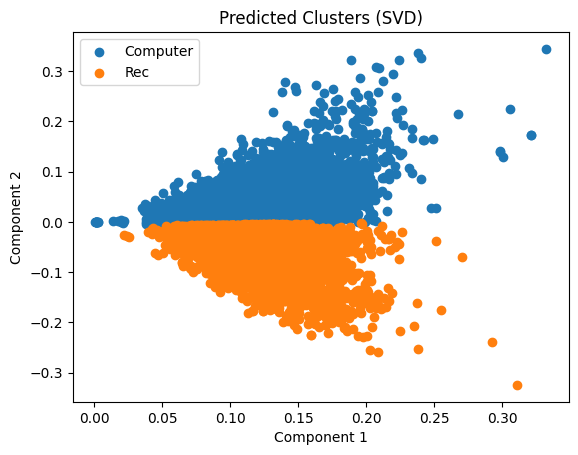

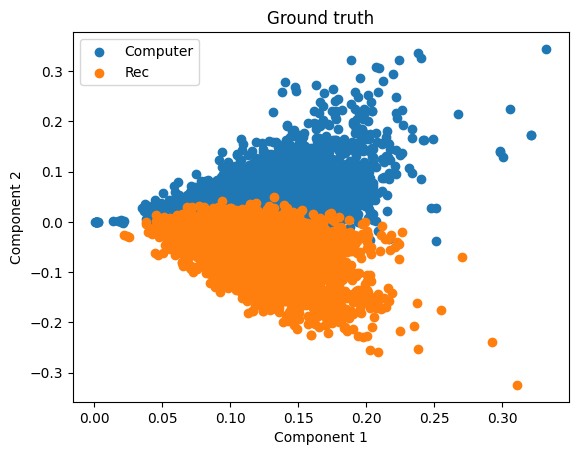

In [51]:
# Use r = 2 components based on results from Question 5
r = 2

# SVD
svd = TruncatedSVD(n_components = r)
lsa_matrix = svd.fit_transform(X_tfidf)

# Fit
kmeans.fit(lsa_matrix)

# Get labels for each data point
labels = kmeans.labels_

# Visualize clusters
lsa_2d = lsa_matrix[:, :2] # Get top two components

# Put top two components and label in dataframe
lsa_df = pd.DataFrame(lsa_2d, columns = ['Component 1', 'Component 2'])
lsa_df['Label'] = labels
lsa_df['Ground truth'] = newsgroups_labels

# Plot results
plt.scatter(lsa_df[lsa_df['Label'] == 0]['Component 1'], lsa_df[lsa_df['Label'] == 0]['Component 2'], label = 'Computer')
plt.scatter(lsa_df[lsa_df['Label'] == 1]['Component 1'], lsa_df[lsa_df['Label'] == 1]['Component 2'], label = 'Rec')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Predicted Clusters (SVD)')
plt.legend()
plt.show()

# Plot ground truth
plt.scatter(lsa_df[lsa_df['Ground truth'] == 0]['Component 1'], lsa_df[lsa_df['Ground truth'] == 0]['Component 2'], label = 'Computer')
plt.scatter(lsa_df[lsa_df['Ground truth'] == 1]['Component 1'], lsa_df[lsa_df['Ground truth'] == 1]['Component 2'], label = 'Rec')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Ground truth (SVD)')
plt.legend()
plt.show()


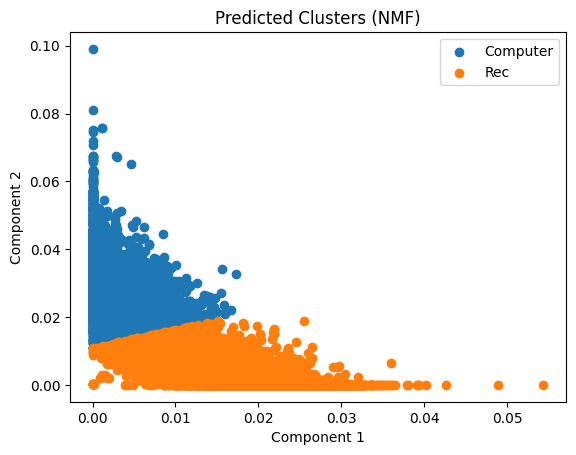

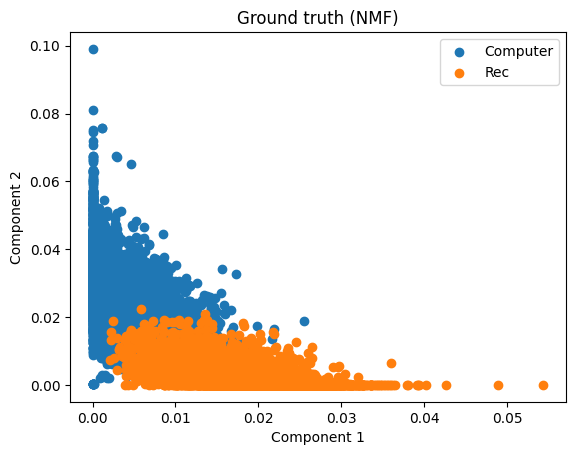

In [52]:
# Use r = 2 components based on results from Question 5
r = 2

# NMF
nmf = NMF(n_components = r, init = 'random', random_state = 0)
nmf_matrix = nmf.fit_transform(X_tfidf)

# Fit
kmeans.fit(nmf_matrix)

# Get labels for each data point
labels = kmeans.labels_

# Visualize clusters
nmf_2d = nmf_matrix[:, :2] # Get top two components

# Put top two components and label in dataframe
nmf_df = pd.DataFrame(nmf_2d, columns = ['Component 1', 'Component 2'])
nmf_df['Label'] = labels
nmf_df['Ground truth'] = newsgroups_labels

# Plot results
plt.scatter(nmf_df[nmf_df['Label'] == 0]['Component 1'], nmf_df[nmf_df['Label'] == 0]['Component 2'], label = 'Computer')
plt.scatter(nmf_df[nmf_df['Label'] == 1]['Component 1'], nmf_df[nmf_df['Label'] == 1]['Component 2'], label = 'Rec')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Predicted Clusters (NMF)')
plt.legend()
plt.show()

# Plot ground truth
plt.scatter(nmf_df[nmf_df['Ground truth'] == 0]['Component 1'], nmf_df[nmf_df['Ground truth'] == 0]['Component 2'], label = 'Computer')
plt.scatter(nmf_df[nmf_df['Ground truth'] == 1]['Component 1'], nmf_df[nmf_df['Ground truth'] == 1]['Component 2'], label = 'Rec')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Ground truth (NMF)')
plt.legend()
plt.show()

### Question 9

TODO